In [91]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from IPython.display import display, Image
from ipywidgets import widgets, interact
from scipy.ndimage import gaussian_filter, find_objects
from copy import deepcopy
from glob import glob
import matplotlib.patches as patches
from hagelslag.processing.EnhancedWatershedSegmenter import EnhancedWatershed, rescale_data
from hagelslag.processing.Hysteresis import Hysteresis
from hagelslag.data.ModelOutput import ModelOutput
from hagelslag.processing.ObjectMatcher import ObjectMatcher, shifted_centroid_distance, centroid_distance
from hagelslag.processing.STObject import STObject
from matplotlib.colors import ListedColormap
from hagelslag.processing.tracker import label_storm_objects, extract_storm_objects

In [5]:
model_path = "../testdata/spring2015_unidata/"
ensemble_name = "SSEF"
member ="wrf-s3cn_arw"
run_date = datetime(2015, 6, 4)
# We will be using the uh_max (hourly max 2-5 km Updraft Helicity) variable for this exercise
# cmpref (simulated composite radar reflectivity) is also available.
variable = "cmpref"
start_date = run_date + timedelta(hours=12)
end_date = run_date + timedelta(hours=29)
model_grid = ModelOutput(ensemble_name, 
                         member, 
                         run_date, 
                         variable, 
                         start_date, 
                         end_date,
                         model_path,
                         map_file="../mapfiles/ssef2015.map",
                         single_step=False)
model_grid.load_data()
model_grid.load_map_info("../mapfiles/ssef2015.map")

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/hagelslag-0.2-py3.6.egg/hagelslag/data/ModelGrid.py:39: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=self.frequency)


In [6]:
model_grid.data.shape

(18, 1155, 1683)

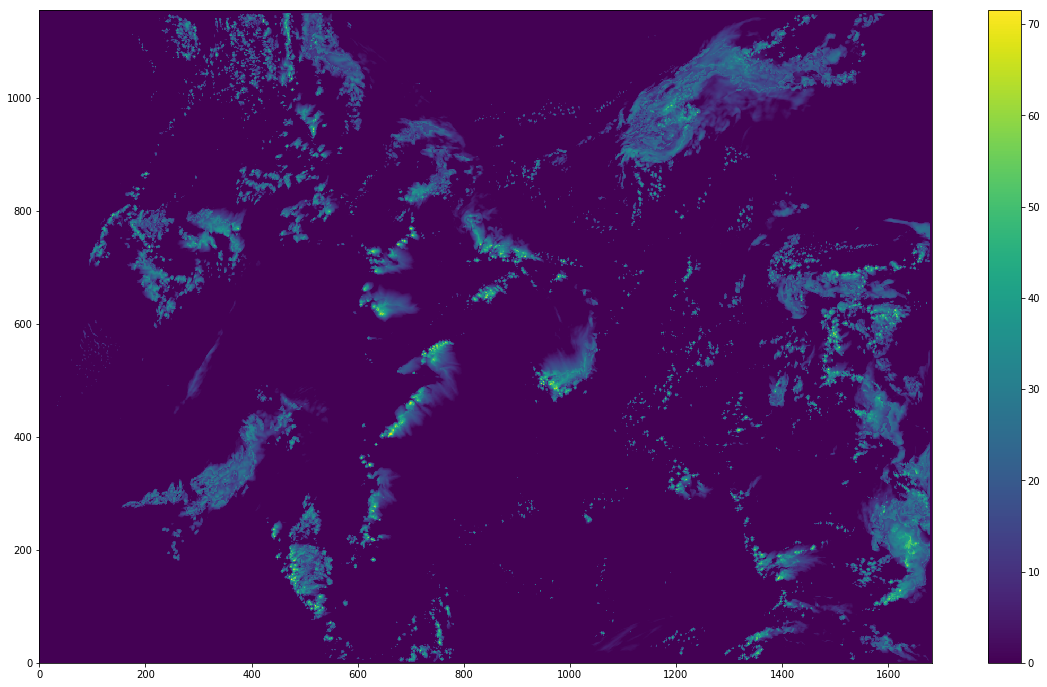

In [94]:
plt.figure(figsize=(20, 12))
plt.pcolormesh(model_grid.data[12])
plt.colorbar()

In [7]:
data = model_grid.data[10]
scaled_data = rescale_data(data, 20, data.max(), 0, 100)

In [55]:
scaled_data.min()

-6.6910086

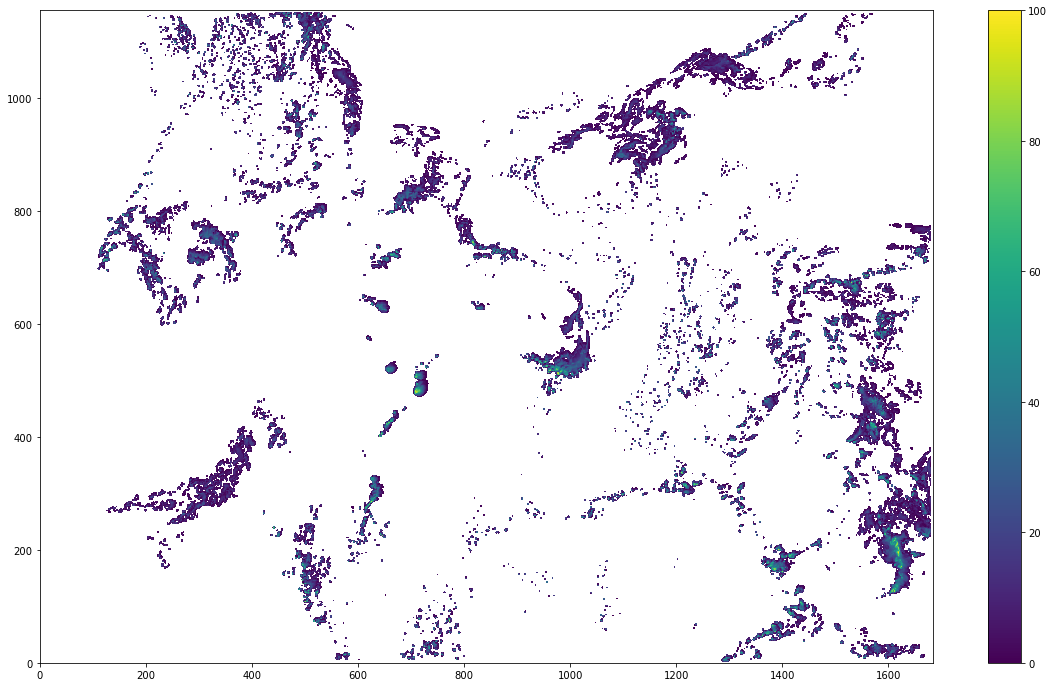

In [8]:
plt.figure(figsize=(20, 12))
plt.pcolormesh(np.ma.array(scaled_data, mask=scaled_data<0))
plt.colorbar()

In [107]:
from scipy.ndimage import label
from scipy.ndimage import label, maximum, find_objects

class Hysteresis2(object):
    """
    Object segmentation method that identifies objects as contiguous areas with all pixels above a low
    threshold and contain at least one pixel above a high threshold.

    Attributes:
        low_thresh: lower threshold value
        high_thresh: higher threshold value
    """

    def __init__(self, low_thresh, high_thresh):
        self.low_thresh = low_thresh
        self.high_thresh = high_thresh
        return

    def label(self, input_grid):
        """
        Label input grid with hysteresis method.

        Args:
            input_grid: 2D array of values.

        Returns:
            Labeled output grid.
        """
        unset = 0
        high_labels, num_labels = label(input_grid > self.high_thresh)
        region_ranking = np.argsort(maximum(input_grid, high_labels, index=np.arange(1, num_labels + 1)))[::-1]
        output_grid = np.zeros(input_grid.shape, dtype=int)
        stack = []
        for rank in region_ranking:
            label_num = rank + 1
            label_i, label_j = np.where(high_labels == label_num)
            for i in range(label_i.size):
                if output_grid[label_i[i], label_j[i]] == unset:
                    stack.append((label_i[i], label_j[i]))
            while len(stack) > 0:
                index = stack.pop(-1)
                output_grid[index] = label_num
                for i in range(index[0] - 1, index[0] + 2):
                    for j in range(index[1] - 1, index[1] + 2):
                        if 0 <= i < output_grid.shape[0] and 0 <= j < output_grid.shape[1]:
                            if (input_grid[i, j] > self.low_thresh) and (output_grid[i, j] == unset):
                                stack.append((i, j))
        return output_grid

    @staticmethod
    def size_filter(labeled_grid, min_size):
        """
        Remove labeled objects that do not meet size threshold criteria.

        Args:
            labeled_grid: 2D output from label method.
            min_size: minimum size of object in pixels.

        Returns:
            labeled grid with smaller objects removed.
        """
        out_grid = np.zeros(labeled_grid.shape, dtype=int)
        slices = find_objects(labeled_grid)
        j = 1
        for i, s in enumerate(slices):
            box = labeled_grid[s]
            size = np.count_nonzero(box.ravel() == (i + 1))
            if size >= min_size and box.shape[0] > 1 and box.shape[1] > 1:
                out_grid[np.where(labeled_grid == i + 1)] = j
                j += 1
        return out_grid

In [127]:
hyst = Hysteresis2(20, 35)
h_labels = hyst.label(gaussian_filter(data, 2))

In [113]:
s_labels = label(data)[0]

In [116]:
s_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

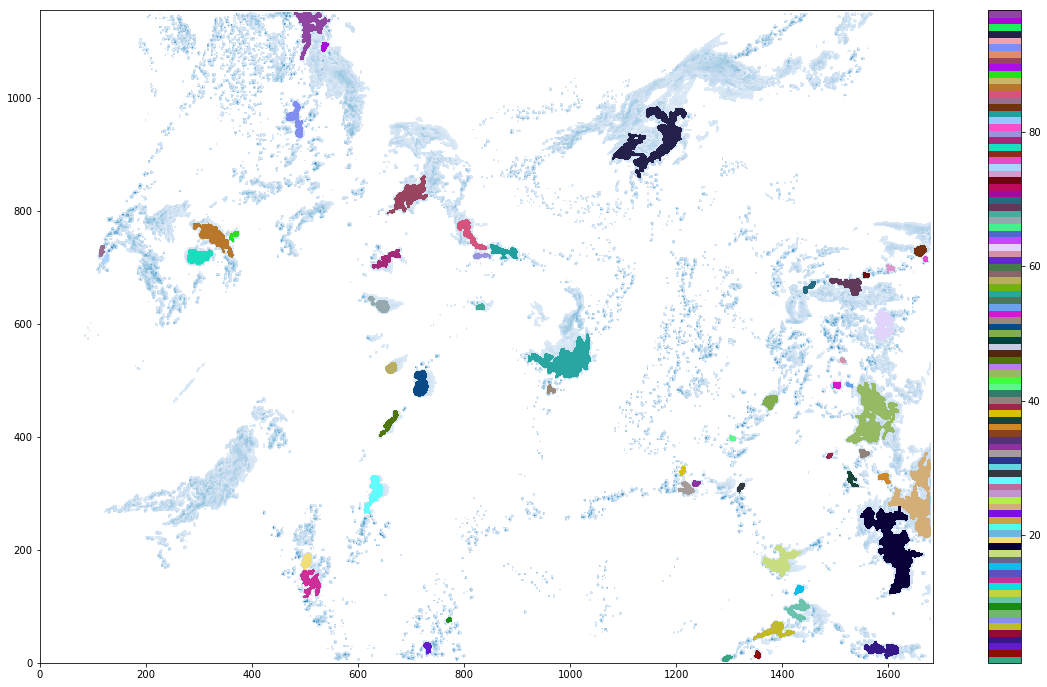

In [128]:
plt.figure(figsize=(20, 12))
pc = plt.pcolormesh(np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
cm = ListedColormap(np.random.random(size=(h_labels.max(), 3)).tolist())

plt.pcolormesh(np.ma.array(h_labels, mask=h_labels <= 0), cmap=cm)
#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.savefig("hyst_out.png", dpi=200, bbox_inches="tight")

In [154]:
labels = label_storm_objects(scaled_data, "ew", 1, 20, min_area=1, max_area=20, max_range=20)

(200, 600)

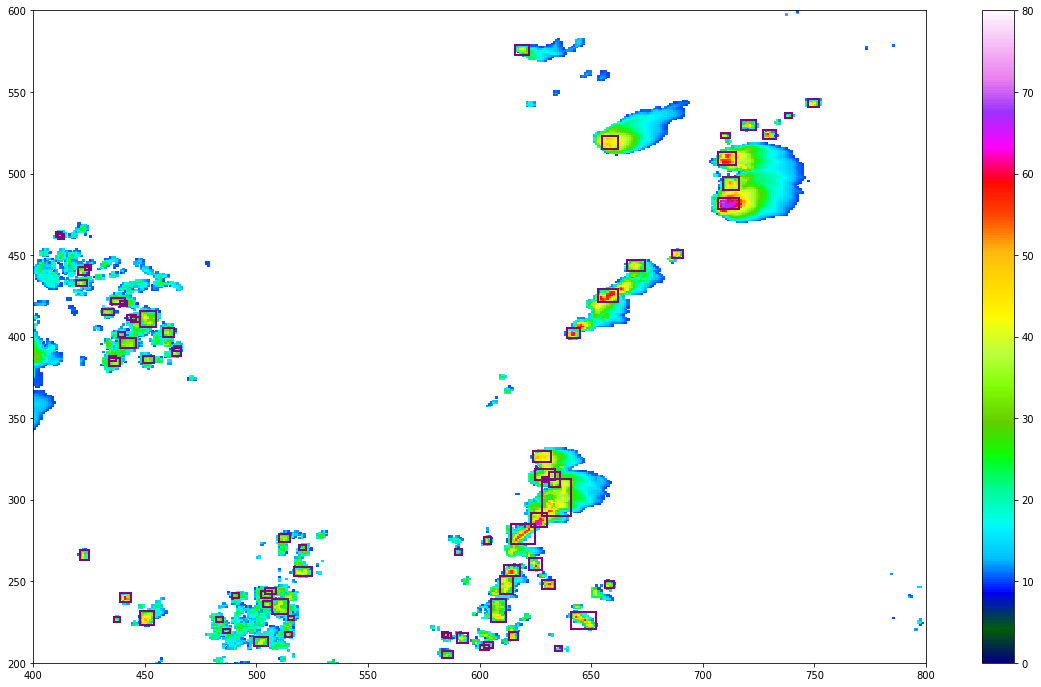

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
lc = ListedColormap(np.random.random(size=(labels.max()+1, 3)).tolist())
colors = np.random.random(size=(labels.max()+1, 3)).tolist()
#ax.pcolormesh(np.ma.array(labels, mask=labels==0), cmap=lc)
pc = ax.pcolormesh(np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="gist_ncar")
plt.colorbar(pc)
objs = find_objects(labels)
areas = np.zeros(len(objs), dtype=int)
for o, obj in enumerate(objs):
        sy = model_grid.i[obj[0].start-1, obj[1].start-1]
        sx = model_grid.j[obj[0].start-1, obj[1].start-1]
        wx = model_grid.j[obj[0].stop + 1, obj[1].stop + 1] - sx
        wy = model_grid.i[obj[0].stop + 1, obj[1].stop + 1] - sy
        area = (wy) * (wx)
        areas[o] = area
        if area > 0:
            ax.add_patch(patches.Rectangle((sx, sy), wx, wy, fill=False, color="purple", lw=2))
    
plt.xlim(400, 800)
plt.ylim(200, 600)


In [79]:
from collections import OrderedDict
from numba import jit
def quantize(input_grid, min_thresh, max_thresh, increment):
    """
    Quantize a grid into discrete steps based on input parameters.

    Args:
        input_grid: 2-d array of values

    Returns:
        Dictionary of value pointing to pixel locations, and quantized 2-d array of data
    """
    pixels = {}
    max_bin = int((max_thresh - min_thresh) / increment)

    for i in range(max_bin+1):
        pixels[i] = []
    data = (np.array(input_grid, dtype=np.int32) - min_thresh) // increment
    data[data < 0] = -1
    data[data > max_bin] = max_bin
    good_points = np.where(data >= 0)
    for g in np.arange(good_points[0].shape[0]):
        pixels[data[(good_points[0][g], good_points[1][g])]].append((good_points[0][g], good_points[1][g]))
    return pixels, data

def find_local_maxima(input_grid, max_size, min_thresh, max_thresh, increment):
    """
    Finds the local maxima in the inputGrid and perform region growing to identify objects.

    Args:
        input_grid: Raw input data.

    Returns:
        array with labeled objects.
    """
    UNMARKED = -1
    GLOBBED = -3
    TOOSMALL = -4
    pixels, q_data = quantize(input_grid, min_thresh, max_thresh, increment)
    max_bin = int((max_thresh - min_thresh) / increment)

    centers = dict()
    for p in pixels.keys():
        centers[p] = []
    marked = np.ones(q_data.shape, dtype=int) * UNMARKED
    MIN_INFL = int(np.round(1 + 0.5 * np.sqrt(max_size)))
    MAX_INFL = 2 * MIN_INFL
    marked_so_far = []
    # Find the maxima. These are high-values with enough clearance
    # around them.
    # Work from high to low bins. The pixels in the highest bin mark their
    # neighborhoods first. If you did it from low to high the lowest maxima
    # would mark their neighborhoods first and interfere with the identification of higher maxima.
    for b in sorted(pixels.keys(),reverse=True):
        # Square starts large with high intensity bins and gets smaller with low intensity bins.
        infl_dist = MIN_INFL + int(np.round(float(b) / max_bin * (MAX_INFL - MIN_INFL)))
        for p in pixels[b]:
            if marked[p] == UNMARKED:
                ok = False
                del marked_so_far[:]
                # Temporarily mark unmarked points in square around point (keep track of them in list marked_so_far).
                # If none of the points in square were marked already from a higher intensity center, 
                # this counts as a new center and ok=True and points will remain marked.
                # Otherwise ok=False and marked points that were previously unmarked will be unmarked.
                for (i, j), v in np.ndenumerate(marked[p[0] - infl_dist:p[0] + infl_dist + 1,
                                                p[1] - infl_dist:p[1]+ infl_dist + 1]):
                    if v == UNMARKED:
                        ok = True
                        marked[i - infl_dist + p[0],j - infl_dist + p[1]] = b

                        marked_so_far.append((i - infl_dist + p[0],j - infl_dist + p[1]))
                    else:
                        # neighborhood already taken
                        ok = False
                        break
                # ok if point and surrounding square were not marked already.
                if ok:
                    # highest point in its neighborhood
                    centers[b].append(p)
                else:
                    for m in marked_so_far:
                        marked[m] = UNMARKED
    return centers, marked, q_data

def grow_local_maxima(centers, q_data, max_size, max_delta):
    UNMARKED = -1
    GLOBBED = -3
    TOOSMALL = -4
    marked[:, :] = np.ones(q_data.shape, dtype=np.int32) * UNMARKED
    deferred_from_last = []
    deferred_to_next = []
    # delta (int): maximum number of increments the cluster is allowed to range over. 
    # Larger d results in clusters over larger scales.
    capture_index = 1
    for delta in range(0, max_delta + 1):
        # Work from high to low bins.
        for b in sorted(centers.keys(), reverse=True):
            bin_lower = b - delta
            deferred_from_last[:] = deferred_to_next[:]
            del deferred_to_next[:]
            foothills = []
            n_centers = len(centers[b])
            tot_centers = n_centers + len(deferred_from_last)
            for i in range(tot_centers):
                # done this way to minimize memory overhead of maintaining two lists
                if i < n_centers:
                    center = centers[b][i]
                else:
                    center = deferred_from_last[i - n_centers]
                if bin_lower < 0:
                    bin_lower = 0
                if marked[center] == UNMARKED:
                    captured = set_maximum(q_data, marked, center, bin_lower, foothills, max_size, capture_index)
                    if not captured:
                        # decrement to lower value to see if it'll get big enough
                        deferred_to_next.append(center)
                    else:
                        capture_index += 1
                        pass
            # this is the last one for this bin
            remove_foothills(q_data, marked, b, bin_lower, centers, foothills)
        del deferred_from_last[:]
        del deferred_to_next[:]
    return marked

def set_maximum(q_data, marked, center, bin_lower, foothills, max_size, capture_index):
    """
    Grow a region at a certain bin level and check if the region has reached the maximum size.

    Args:
        q_data: Quantized data array
        marked: Array marking points that are objects
        center: Coordinates of the center pixel of the region being grown
        bin_lower: Intensity level of lower bin being evaluated
        foothills: List of points that are associated with a center but fall outside the the size or
            intensity criteria
    Returns:
        True if the object is finished growing and False if the object should be grown again at the next
        threshold level.
    """
    UNMARKED = -1
    GLOBBED = -3
    TOOSMALL = -4
    as_bin = [] # pixels to be included in peak
    as_glob = []   # pixels to be globbed up as part of foothills
    marked_so_far = []  # pixels that have already been marked
    will_be_considered_again = False
    as_bin.append(center)
    center_data = q_data[center]
    while len(as_bin) > 0:
        p = as_bin.pop(-1) # remove and return last pixel in as_bin
        if marked[p] != UNMARKED: # already processed
            continue
        marked[p] = capture_index
        #marked[p] = q_data[center]
        marked_so_far.append(p)

        # check neighbors
        for index,val in np.ndenumerate(marked[p[0] - 1:p[0] + 2, p[1] - 1:p[1] + 2]):
            # is neighbor part of peak or part of mountain?
            if val == UNMARKED:
                pixel = (index[0] - 1 + p[0],index[1] - 1 + p[1])
                p_data = q_data[pixel]
                if (not will_be_considered_again) and (p_data >= 0) and (p_data <= center_data):
                    will_be_considered_again = True
                if p_data >= bin_lower:
                    as_bin.append(pixel)
                # Do not check that this is the closest: this way, a narrow channel of globbed pixels form
                elif p_data >= 0:
                    as_glob.append(pixel)
    if bin_lower == 0:
        will_be_considered_again = False
    big_enough = len(marked_so_far) >= max_size
    if big_enough:
        # remove lower values within region of influence
        foothills.append((center, as_glob))
    elif will_be_considered_again: # remove the check if you want to ignore regions smaller than max_size
        for m in marked_so_far:
            marked[m] = UNMARKED
        del as_bin[:]
        del as_glob[:]
        del marked_so_far[:]
    return big_enough or (not will_be_considered_again)

def remove_foothills(q_data, marked, bin_num, bin_lower, centers, foothills):
    """
    Mark points determined to be foothills as globbed, so that they are not included in
    future searches. Also searches neighboring points to foothill points to determine
    if they should also be considered foothills.

    Args:
        q_data: Quantized data
        marked: Marked
        bin_num: Current bin being searched
        bin_lower: Next bin being searched
        centers: dictionary of local maxima considered to be object centers
        foothills: List of foothill points being removed.
    """
    UNMARKED = -1
    GLOBBED = -3
    TOOSMALL = -4
    hills = []
    for foot in foothills:
        center = foot[0]
        hills[:] = foot[1][:]
        # remove all foothills
        while len(hills) > 0:
            # mark this point
            pt = hills.pop(-1)
            marked[pt] = GLOBBED
            for s_index, val in np.ndenumerate(marked[pt[0]-1:pt[0]+2,pt[1]-1:pt[1]+2]):
                index = (s_index[0] - 1 + pt[0], s_index[1] - 1 + pt[1])
                # is neighbor part of peak or part of mountain?
                if val == UNMARKED:
                    # will let in even minor peaks
                    if (q_data[index] >= 0) and \
                            (q_data[index] < bin_lower) and \
                            ((q_data[index] <= q_data[pt]) or is_closest(index, center, centers, bin_num)):
                        hills.append(index)
    del foothills[:]

def is_closest(point, center, centers, bin_num):
    bin_thresh = int(bin_num / 2)
    p_arr = np.array(point, dtype=np.int32)
    c_arr = np.array(center, dtype=np.int32)
    my_dist = np.sum(np.power(p_arr - c_arr, 2))
    for o_bin in range(bin_thresh, len(centers.keys())):
        for c in centers[o_bin]:
            oc_arr = np.array(c)
            if np.sum(np.power(p_arr - oc_arr, 2)) < my_dist:
                return False
    return True

In [85]:
centers, marked, q_data = find_local_maxima(gaussian_filter(scaled_data, 2), 200, 1, 100, 10)

In [86]:
all_labels = grow_local_maxima(centers, q_data, 200, 0)

In [87]:
all_labels.max()

362

In [88]:
cm = ListedColormap(np.random.random(size=(all_labels.max(), 3)).tolist())

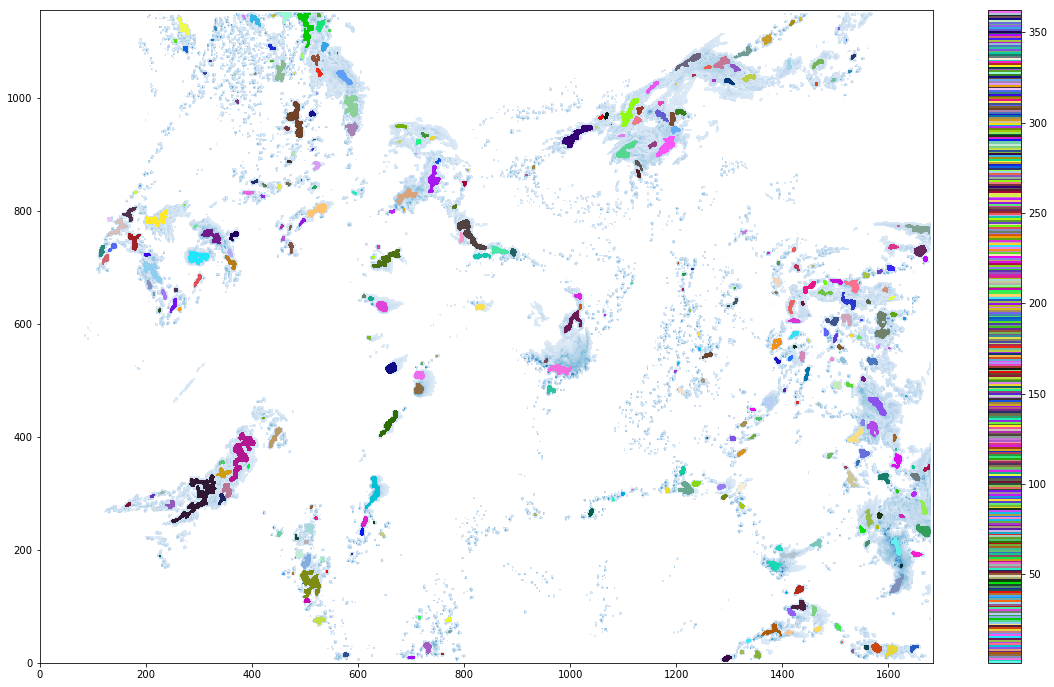

In [90]:
plt.figure(figsize=(20, 12))
pc = plt.pcolormesh(np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
plt.pcolormesh(np.ma.array(all_labels, mask=all_labels <= 0), cmap=cm)

#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.savefig("ew_out.png", dpi=200, bbox_inches="tight")

In [ ]:
import numba
numba.__version__

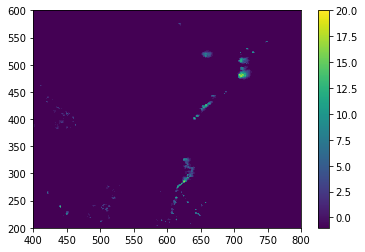

In [173]:
plt.pcolormesh(np.ma.array(q_data))
plt.xlim(400, 800)
plt.ylim(200, 600)
plt.colorbar()

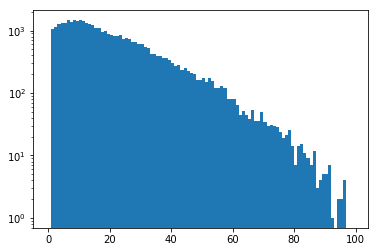

In [19]:
plt.hist(scaled_data.ravel()[all_labels.ravel() > 0], bins=np.arange(0, 100))
plt.gca().set_yscale("log")

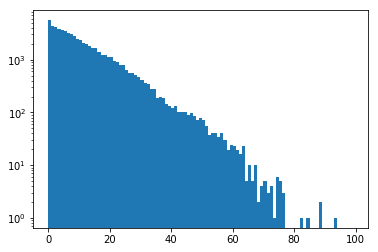

In [21]:
plt.hist(scaled_data.ravel()[all_labels.ravel() < 0], np.arange(0, 100))
plt.gca().set_yscale("log")

In [78]:
np.any(np.where(labels > 0, 1, 0) != np.where(labels_2 > 0, 1, 0))

True